In [0]:
!pip install tensorflow==2.0.0

In [18]:
import tensorflow as tf
tf.version

<module 'tensorflow_core._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v2/version/__init__.py'>

In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv('assignment_train.csv')
df.columns = ['id', 'text', 'emotion']
df.head()

emotion2id = {}
id2emotion = {}
id_ = 0

Mapping all the emotins in the dataset
to integer ids
for index, row in df.iterrows():
    if row['emotion'] not in emotion2id:
        emotion2id[row['emotion']] = id_
        id2emotion[id_] = row['emotion']
        id_ += 1

,id,text,emotion
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [0]:
with open('emotion2id.map', 'w') as e:
    for k, v in emotion2id.items():
        e.write(str(k) + '\t' + str(v) + '\n')

with open('id2emotion.map', 'w') as e:
    for k, v in id2emotion.items():
        e.write(str(k) + '\t' + str(v) + '\n')

In [26]:
df['emotion'] = df['emotion'].apply(lambda x: emotion2id[x])
df.head()

,id,text,emotion
0,27383,i feel awful about it too because it s my job ...,0
1,110083,im alone i feel awful,0
2,140764,ive probably mentioned this before but i reall...,1
3,100071,i was feeling a little low few days back,0
4,2837,i beleive that i am much more sensitive to oth...,2


In [0]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2)
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(df['text'])
data = tokenizer.texts_to_sequences(train['text'])
data = tf.keras.preprocessing.sequence.pad_sequences(data, padding='post', maxlen=120)

In [0]:
val_data = tokenizer.texts_to_sequences(valid['text'])
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, padding='post', maxlen=120)

In [0]:
MAX_SEQUENCE_LENGTH=120
EMBEDDING_DIM = 128

In [0]:
# create embedding layer
embedding_layer = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    EMBEDDING_DIM,
    embeddings_initializer='glorot_uniform',
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)

In [0]:
seq = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
emb = embedding_layer(seq)

# 1D convolutional networks can be used to process 
# sequential/temporal data which makes them well suited 
# for text processing tasks. They can recognize local 
# patterns in a sequence by processing multiple words 
# at the same time. 
conv_1d = tf.keras.layers.Conv1D(filters=64,
                                 kernel_size=3,
                                 padding='same',
                                 activation='relu')(emb)
max_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_1d)
bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64,
                         dropout=0.4,
                         recurrent_dropout=0.25))(max_pool)
preds = tf.keras.layers.Dense(6, activation='softmax')(bi_lstm)

In [0]:
classifier = tf.keras.Model(seq, preds)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                          min_delta=0,
                                          patience=3,
                                          restore_best_weights=True,
                                          verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                              factor=0.5,
                                              verbose=1,
                                              patience=2,
                                              min_lr=0.000001)

In [34]:
classifier.summary()
print("Training Progress:")
history = classifier.fit(data, train['emotion'].values, validation_data=(val_data, valid['emotion'].values),
          epochs=24, batch_size=128,
          callbacks=[early_stopping, reduce_lr])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 128)          7570304   
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 64)           24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 7,661,766
Trainable params: 7,661,766
Non-trainable params: 0
___________________________________________________

In [0]:
classifier.save('classifier.h5')

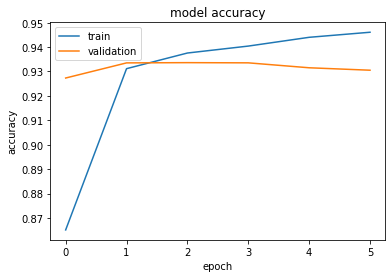

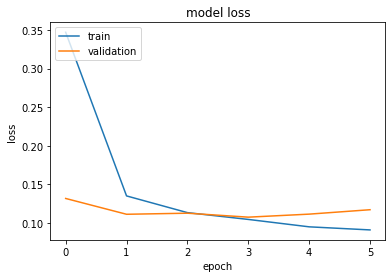

In [37]:
import matplotlib.pyplot as plt

#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [66]:
df = pd.read_csv('assignment_test.csv')
df.columns = ['id', 'text', 'emotion']
df.head()
df['emotion'] = df['emotion'].apply(lambda x: emotion2id[x])
df.head()

,id,text,emotion
0,31367,i feel drained today,0
1,14724,i feel so deeply loved by her in a way that it...,2
2,18693,i do about feeling useless,0
3,62664,i feel so honoured to be featured today and it...,1
4,14865,i can feel her respond with an innocent childs...,1


In [0]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
test_data = tokenizer.texts_to_sequences(df['text'])
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, padding='post', maxlen=120)

In [0]:
classifier = tf.keras.models.load_model('classifier.h5')
score, acc = classifier.evaluate(test_data, df['emotion'].values)

In [43]:
print("Accuracy of the model: {}".format(acc))
print("Score: {}".format(score))

Accuracy of the model: 0.9342061281204224
Score: 0.11344061831866185


In [0]:
prediction = classifier.predict(test_data)

In [0]:
emotions = []
for pred in prediction:
    b = tf.math.argmax(pred)
    c = tf.keras.backend.eval(b)
    
    emotions.append(id2emotion[c])

In [70]:
df['emotion'] = df['emotion'].apply(lambda x: id2emotion[x])

df['predicted_emotion'] = emotions
df.head()

,id,text,emotion,predicted_emotion
0,31367,i feel drained today,sadness,sadness
1,14724,i feel so deeply loved by her in a way that it...,love,love
2,18693,i do about feeling useless,sadness,sadness
3,62664,i feel so honoured to be featured today and it...,joy,joy
4,14865,i can feel her respond with an innocent childs...,joy,joy


In [0]:
df.to_csv('predicted_test_data.csv')